## Generate word2vec embeddings using TensorFlow

Use Noise Contrastive Estimator (NCE) as a loss function

Modified from original code here: http://adventuresinmachinelearning.com/word2vec-tutorial-tensorflow/

#### Some imports to make code compatible with Python 2 as well as 3

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import collections
import math
import os
import random
import zipfile

In [3]:
from six.moves import urllib
from six.moves import xrange

In [4]:
import numpy as np
import tensorflow as tf

In [5]:
print(np.__version__)
print(tf.__version__)

1.13.1
1.3.0


In [6]:
DOWNLOADED_FILENAME = 'SampleText.zip'

def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
    statinfo = os.stat(DOWNLOADED_FILENAME)

    if statinfo.st_size == expected_bytes:
        print('Found and verified file from this path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)

        raise Exception(
            'Failed to verify file from: ' + url_path + '. Can you get to it with a browser?')

In [7]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    
    return words

In [8]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

Found and verified file from this path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


#### Get the list of words from the the sample, this is our entire vocabulary

In [9]:
vocabulary = read_words()

In [10]:
len(vocabulary)

17005207

In [11]:
vocabulary[:25]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes']

### Build the data set used to generate word2vec embeddings

* *words* A list of all words in the input dataset
* *n_words* The number of words to include in the dataset. We use the most frequently occurring n_words

Return values are:

* *word_counts* The most frequently occurring words and the corresponding frequencies
* *word_indexes* The list of index values which uniquely identifies each word in the dataset
* *dictionary* Mapping from a word to its unique index
* *reversed_dictionary* Mapping from the unique index to the word

In [12]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words - 1))
 
    # Only the most common words are added to the dictionary
    dictionary = dict()
    
    for word, _ in word_counts:
        # The current length of the dictionary is the unique index of this word
        # added to the dictionary
        dictionary[word] = len(dictionary)
    
    word_indexes = list()
    
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNKNOWN']
            unknown_count += 1
        
        word_indexes.append(index)
    
    # Count of unknown words
    word_counts[0][1] = unknown_count
    
    # Map from unique indexes to word
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return  word_counts, word_indexes, dictionary, reversed_dictionary

In [13]:
VOCABULARY_SIZE = 100000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [14]:
word_counts[:10]

[['UNKNOWN', 189230],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [15]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [17]:
for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])

hrerbunker : 54289
ethicists : 43633
refits : 75611
inmarsat : 18736
impracticable : 87209
elitists : 82373
vz : 79055
kota : 48526
hanse : 31849
anonymous : 6412


In [23]:
for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

43127 : warps
95758 : xero
60708 : wadb
98901 : rothrock
30757 : grooming
35425 : wattle
20184 : curing
53621 : mukhabarat
12957 : warlord
63097 : fsn


### Return one batch of data and the corresponding labels for training

* *word_indexes* A list of unique indexes which identifies each word in the dataset. The most popular words have the lowest index values
* *batch_size* The number of elements in each batch
* *num_skips* The number of words to choose from the neighboring words within the skip_window. Each input word will appear num_skips times in the batch with a context or neighboring word as the corresponding label
* *skip_window* How many words to consider around one input word

In [25]:
# Global index into words maintained across batches
global_index = 0

def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index

    # For every input we find num_skips context words within a window
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    # batch = [1, 2, 3, .... batch_size]
    # labels = [[1], [2], [3], ..., [batch_size]]
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # The span of a window includes the skip_window elements on each side
    # of the input word plus the word itself
    span = 2 * skip_window + 1  # [ skip_window input_word skip_window ]

    # A deque is double-ended queue which supports memory efficient appends
    # and pops from each side
    buffer = collections.deque(maxlen=span)

    # Initialize the deque with the first words in the deque
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    for i in range(batch_size // num_skips):
        target = skip_window  # input word at the center of the buffer
        targets_to_avoid = [skip_window]

        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window]  # this is the input word
            labels[i * num_skips + j, 0] = buffer[target]  # these are the context words
        
        # The first word from the buffer is removed automatically when a new word
        # is added in at the end
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
    
    # Backtrack a little bit to avoid skipping words in the end of a batch, these
    # words will be captured in the next batch
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)

    return batch, labels

In [26]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [27]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156])

In [28]:
labels

array([[3081],
       [  59],
       [   2],
       [ 156],
       [   6],
       [ 128],
       [ 156],
       [  46],
       [  59],
       [ 742]])

In [29]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ": ", reversed_dictionary[labels[i][0]])

of :  originated
of :  used
abuse :  of
abuse :  against
first :  a
first :  early
used :  against
used :  first
against :  used


### Initialize some variables to build and train the skip-gram model

* *batch_size*: The size of the batch to use in training
* *embedding_size*: Dimensions of the embedding vector i.e. how many features we use to represent a word
* *skip_window*: How many words to include in the context, this is to the left and right
* *num_skips*: How many context words to associate with each target word

In [30]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

# Reset the global index because we updated while testing the batch code
global_index = 0

### Choose some words at random to validate our trained model

* *valid_size*: Number of words to evaluate our model, we'll use these words to see how similar the closest words are
* *valid_window*: The window from where we draw the words to run validation on, only pick from the most commonly used words

Choose the set of words from the top 100 at random

In [31]:
valid_size = 16  
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

### Number of negative examples to sample for NCE loss calculation

In [32]:
num_samples = 64

### Input placeholder to feed data in batches

In [33]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

### Set up a constant to hold validation data

In [34]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Embeddings are word representations that will be generated by word2vec

Initialize a variable to hold the embeddings and embeddings for specific words can be accessed using *tf.nn.embedding_lookup*

NOTE: Embeddings and NCE losses only work on the CPU in TensorFlow, GPU support has not been added yet

In [35]:
embeddings = tf.Variable(
    tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### Construct weights and biases to hold the NCE (Noise Contrastive Estimation) loss

In [36]:
nce_weights = tf.Variable(
    tf.truncated_normal([VOCABULARY_SIZE, embedding_size],
                        stddev=1.0 / math.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [37]:
loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_samples,
                     num_classes=VOCABULARY_SIZE))

In [38]:
 optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

### Normalize the embeddings vector to calculate cosine similarity between words

*normalized_vector = vector / L2 norm of vector*

In [39]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / l2_norm

#### Look up the normalized embeddings of the words we use to validate our model

In [40]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

#### Find the cosine similarity of the validation words against all words in our vocabulary

In [41]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [42]:
init = tf.global_variables_initializer()

In [43]:
num_steps = 200001

In [44]:
final_embeddings = None

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            word_indexes, batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")
            
    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  301.796142578
Nearest to who: tipping, supersonics, monroe, sinuous, bunten, cairo, vara, toolbars,
Nearest to the: moragas, eurasians, mendeleev, adys, crystallized, corrupted, ambuscades, encephalopathy,
Nearest to will: magister, solicitation, kaifu, odwigowo, inuits, anat, hammersley, practical,
Nearest to over: pris, pedrolino, flocked, itv, climatic, ladislaus, ral, keyesville,
Nearest to is: roles, biscayne, teltow, wollongong, asq, prospero, tauris, intel,
Nearest to d: facilitated, obywatelska, amontillado, retail, cafe, ripe, huari, orla,
Nearest to are: pablo, clemson, ultimate, azov, neo, minarets, epicurean, communitarian,
Nearest to see: willard, rags, wilfrid, prez, dubbings, fringe, papillon, protected,
Nearest to such: optimized, amplitude, absorbed, babbage, jotuns, nestled, texts, sulphate,
Nearest to i: byggdist, romain, einbecker, omnisexual, preliminary, shakhbut, sinnott, umayyad,
Nearest to new: bucking, utulei, parceled, leopardi, irr

Average loss at step  82000 :  6.09433858883
Average loss at step  84000 :  5.89167889607
Average loss at step  86000 :  5.98344822586
Average loss at step  88000 :  5.94875478196
Average loss at step  90000 :  5.87125689161
Average loss at step  92000 :  5.57331951463
Average loss at step  94000 :  5.86200480795
Average loss at step  96000 :  5.74657913148
Average loss at step  98000 :  5.51388713944
Average loss at step  100000 :  5.84326822495
Nearest to who: he, by, tele, once, and, then, which, specified,
Nearest to the: its, a, their, another, this, dasyprocta, any, each,
Nearest to will: would, can, may, could, must, to, bpp, when,
Nearest to over: before, when, until, jubilees, during, since, hikari, but,
Nearest to is: was, are, lissodelphis, arenas, became, wct, tight, has,
Nearest to d: b, sarajevo, m, r, UNKNOWN, novella, c, collaborative,
Nearest to are: were, is, lissodelphis, recycling, precipitated, many, carabiners, calming,
Nearest to see: cpa, mass, willard, bisons, 

Average loss at step  182000 :  5.05409136069
Average loss at step  184000 :  5.17323086524
Average loss at step  186000 :  4.97159124434
Average loss at step  188000 :  5.05711169076
Average loss at step  190000 :  5.09927805686
Average loss at step  192000 :  5.11655152345
Average loss at step  194000 :  5.09037402523
Average loss at step  196000 :  5.0096207509
Average loss at step  198000 :  5.02500193095
Average loss at step  200000 :  4.86157756913
Nearest to who: widtsoe, tele, gaba, legs, he, never, successors, kadi,
Nearest to the: another, a, aum, its, dasyprocta, flageolet, leofa, each,
Nearest to will: would, could, must, may, can, might, should, cannot,
Nearest to over: around, within, off, during, before, out, following, through,
Nearest to is: was, became, iie, arenas, are, toontown, olcott, seceded,
Nearest to d: b, c, singer, rang, r, alert, novella, writer,
Nearest to are: were, include, is, precipitated, lissodelphis, many, recycling, musket,
Nearest to see: includes

In [45]:
def save_words_embeddings(embeddings, word_counts):
    
    np.save('embeddings.npy', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
    
save_words_embeddings(final_embeddings, word_counts)

### Visualize the embeddings

In [46]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'

    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)

        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)
    plt.show(filename)

In [47]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

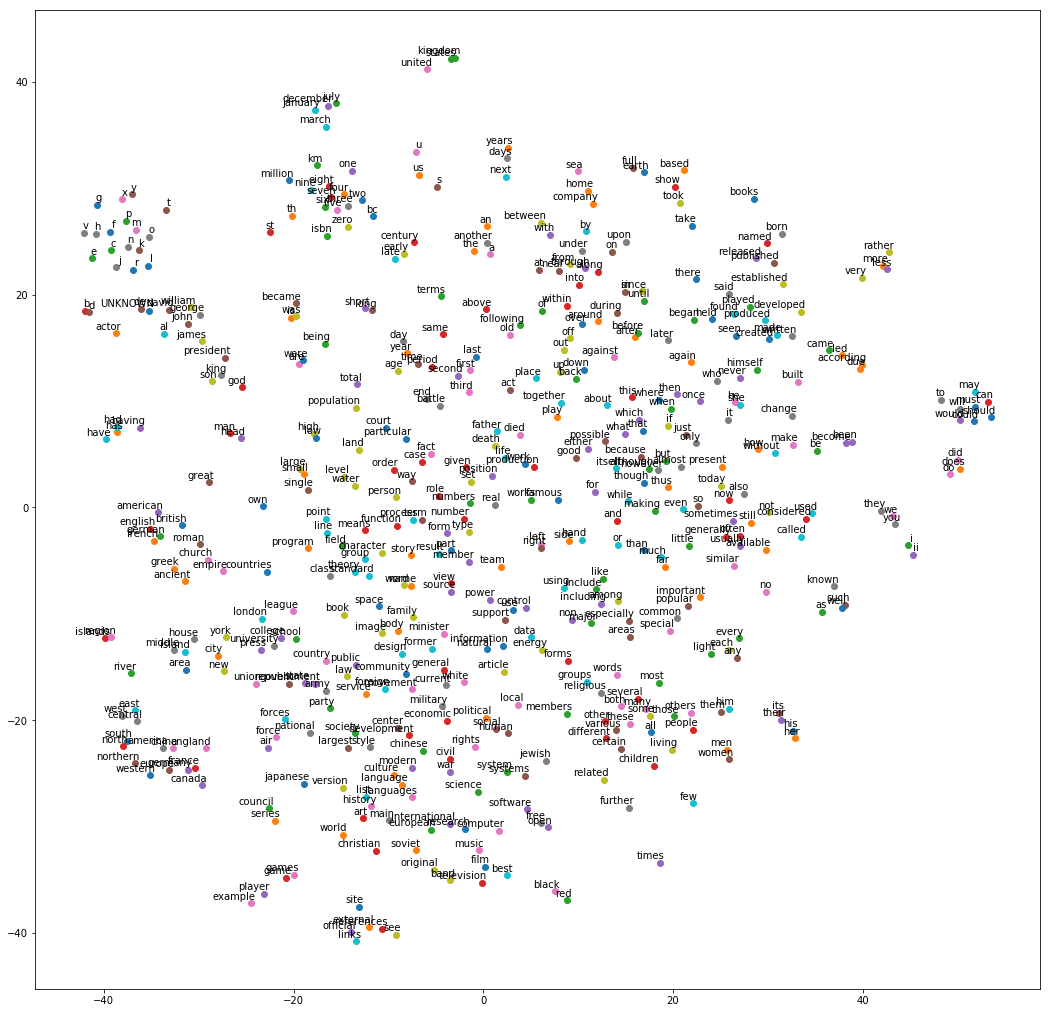

In [48]:
plot_with_labels(low_dim_embs, labels)